# **Принятие решений в бизнесе**

**Заказчик**  

Интернет-магазин

**Цель проекта**  

   - Необходимость приоритизировать гипотезы из списка гипотез, предоставленных отделом Маркетинга;

   - Анализа результатов проведенного А/В-тестирования и аргументация решения по результатам теста.

Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Описание данных**

   - список гипотез (файл hypothesis.csv)

Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.  

   - информация о заказах пользователей в интернет-магазине (файл orders.csv.)  

transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

   - информация о посещениях пользователями интернет-магазина (файл visitors.csv)  

date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста.  

**План работы:**  
  
  
  - Обзор и предобработка данных;
  - Приоритезация гипотез;
  - Анализ А/В-теста;
  - Вывод


## Обзор и предобработка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

from scipy import stats as st

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# выставляем ограничение на количество знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# игнорируем предупреждения
warnings.filterwarnings(action='ignore')

# задаем размер графика
sns.set(rc={'figure.figsize':(10,5)})

In [3]:
# прочтём исходные данные и сохраним их в датафреймы

hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )

In [4]:
# посмотрим на датафрейм hypothesis

hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# посмотрим на датафрейм orders

orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
# посмотрим на датафрейм visitors

visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [7]:
# Посмотрим сколько групп в АВ-тесте

display(orders['group'].unique())
visitors['group'].unique()

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

In [8]:
# Посмотрим даты начала и конца АВ-теста

print('дата начала АВ-теста:', orders['date'].min())
print('дата конца АВ-теста:', orders['date'].max())

дата начала АВ-теста: 2019-08-01
дата конца АВ-теста: 2019-08-31


In [9]:
# Посмотрим количество пользователей в группе А

orders[orders['group']=='A']['visitorId'].count()

557

In [10]:
# Посмотрим количество пользователей в группе В

orders[orders['group']=='B']['visitorId'].count()

640

In [11]:
# Посмотрим есть ли пользователи, попадающие в обе группы теста

orders[orders['group']=='A'].merge(orders[orders['group']=='B'], on='visitorId')

,transactionId_x,visitorId,date_x,revenue_x,group_x,transactionId_y,date_y,revenue_y,group_y
0,2961555356,4069496402,2019-08-15,400,A,1473132782,2019-08-12,640,B
1,2223239646,199603092,2019-08-15,3488,A,437656952,2019-08-02,3488,B
2,62794304,199603092,2019-08-22,6976,A,437656952,2019-08-02,3488,B
3,2971973105,199603092,2019-08-27,2790,A,437656952,2019-08-02,3488,B
4,1941707234,199603092,2019-08-12,6438,A,437656952,2019-08-02,3488,B
...,...,...,...,...,...,...,...,...,...
178,3757656646,4186807279,2019-08-14,4990,A,1759418862,2019-08-21,18560,B
179,3757656646,4186807279,2019-08-14,4990,A,380064637,2019-08-27,13740,B
180,3612788481,2712142231,2019-08-14,2490,A,1251767592,2019-08-16,790,B
181,4052155355,2949041841,2019-08-14,190,A,1329499668,2019-08-14,10380,B


Около 15% пользователей попало в обе группы.

**Вывод**

Мы ознакомились с данными.  
Пропусков нет, столбцы с датами имеют тип object и нужно привести их к типу date.  
Так же нужно проверить данные на наличие дубликатов и привести наименования столбцов к единому стилю.  
Имеем две группы в АВ-тесте с интервалом проведения теста с 2019-08-01 по 2019-08-31.

**Предобработка данных**

In [12]:
# приведём наименования столбцов к хорошему стилю

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis.columns)
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [13]:
# изменим тип данных для столбцов с датами

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [14]:
# проверим таблицы на наличие дубликатов

display(visitors.duplicated().sum())
orders.duplicated().sum()

0

0

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 <a class="tocSkip"> </h2>

Блок предобработки выполнен хорошо: типы и названия скорректированы, есть проверка на пропуски и дубликаты, молодец)
</div>

## Приоритезация гипотез

Отдел маркетинга подготовил список из 9-ти гипотез, параметры которых оценены по шкале от 0 до 10.

Применим один из самых популярных методов приоритезации гипотез - ICE (от. англ.: Impact -Влияние, Confidence-Уверенность, Effort-Усилия).

In [15]:
hypothesis['ice'] = hypothesis.impact * hypothesis.confidence / hypothesis.efforts

display(hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Этот метод показывает, что наиболее приоритетной для исследования являеся гипотеза под индексом 8 (Запустить акцию, дающую скидку на товар в день рождения), затем идут гипотезы под индексами 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей) и 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок).

Добавим к расчету параметр Reach (англ.: Охват) и приоритезируем гипотезы по методу RICE.

In [16]:
hypothesis['rice'] = hypothesis.reach * hypothesis.impact * hypothesis.confidence / hypothesis.efforts
display(hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Этот метод расставил приоритезацию иначе- первое место заняла гипотеза под индексом 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), а гипотеза с индексом 8 (Запустить акцию, дающую скидку на товар в день рождения) с первого места ушла на пятое.  
Данная приоритезация более точная, так как используется дополнительный важный критерий - охват пользователей.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>
    
Приоритизация гипотез проведена успешна! Молодец, что выводишь таблицу дважды, каждый раз с сортировкой по одному из фреймоврков и округляешь значения, так различия в их работе будут максимально наглядными. Согласна с твоими выводами по поводу их различия.
</div>   

## Анализ A/B-теста

### **Кумулятивные метрики**

Чтобы построить графики по кумулятивным (накапливаемым) данным, необходимо собрать агрегированный датафрейм, содержащий информацию о дате, группе (А или В), кумулятивных количестве заказов и пользователей их оформивших, среднем чеке и
о кумулятивном количестве посетителей магазина.

In [17]:
# создадим массив уникальных пар значений дат и групп теста
dates_grouped = orders[['date', 'group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])

orders_grouped.head(6)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996


In [18]:
# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head(6)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803


In [19]:
# объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [20]:
# Посмотрим совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных

print('дата начала АВ-теста:', cumulative_data['date'].min())
print('дата конца АВ-теста:', cumulative_data['date'].max())

дата начала АВ-теста: 2019-08-01 00:00:00
дата конца АВ-теста: 2019-08-31 00:00:00


Всё в порядке,- даты начала и конца теста в соданном датафрейме cumulative_data совпали с исходными датами.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 v_2 <a class="tocSkip"> </h2>

Отлично)

Построим **графики кумулятивной выручки** по дням и группам A/B-тестирования: 

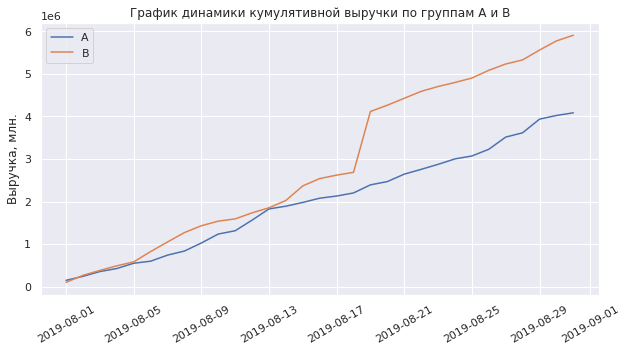

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend();

График показывает, что кумулятивная выручка группы В больше, чем у группы А.
При этом в группе В видим резкий скачок в районе 18-го августа, что может говорить о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>

Правильно)

Построим **графики среднего чека по группам** — разделим кумулятивную выручку на кумулятивное число заказов:

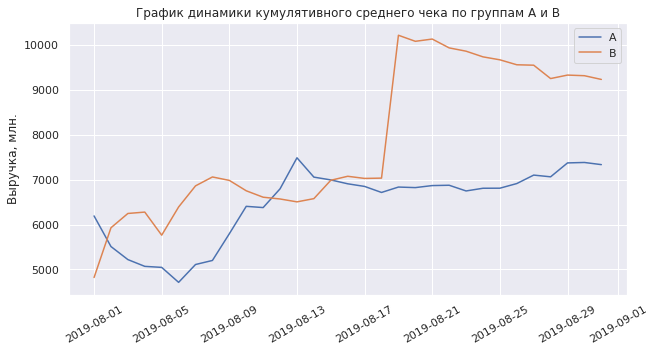

In [22]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend();

Мы видим, что средний чек в группе А через какое-то время стабилизировался.  
Средний чек группы В показал резкий рывок в районе 18 августа, что подтверждает ранее выдвинутое предположение о появлении очень дорогих заказов.

Построим **график относительного изменения кумулятивного среднего чека** группы B к группе A.

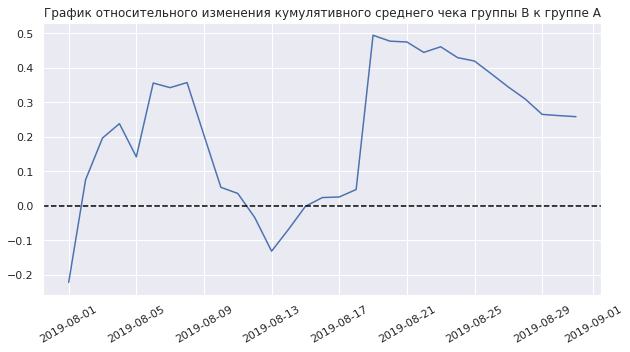

In [23]:
# собираем данные в одном датафрейме
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# cтроим отношение средних чеков
plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30);

График скачет, видно имеют место быть крупные заказы.  
В целом, кумулятивный средний чек группы В преобладает над группой А.

Построим **график кумулятивного среднего количества заказов на посетителя по группам**

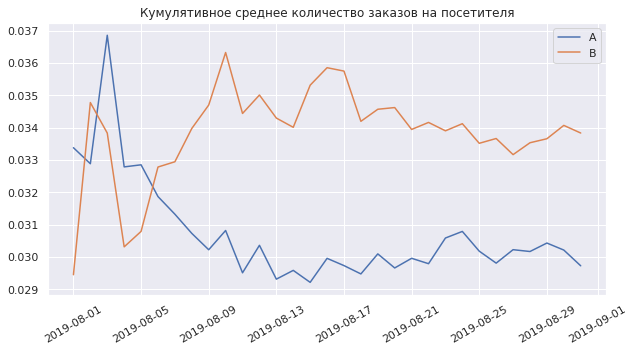

In [24]:
# считаем кумулятивную конверсию посетителя в заказ
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделим данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделим данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xticks(rotation=30);

На графике видно, что уже с 6-го дня наблюдения конверсия посетителя в заказ выше у группы В, и в дальнейшем эта разница составляет примерно 13%.

Построим **график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

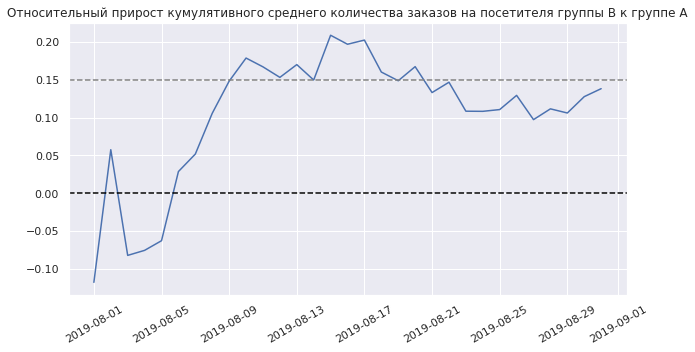

In [25]:
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation=30);

На графике видно,что конверсия группы В уже через несколько дней обгоняет конверсию группы А, резко растёт с 5 по 10 августа и далее немного снижается вплоть до 29 августа.  
Графики выше сигнализировали нам о наличии крупных заказов.
Далее посмотрим на картину по очищенным от выбросов данным.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>

Графики построены и интерпретированы верно, молодец)

Построим **точечный график количества заказов по пользователям**.

In [26]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10))

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершили 8, 9 и 11 заказов. Значительно больше, чем обычный пользователь за месяц.

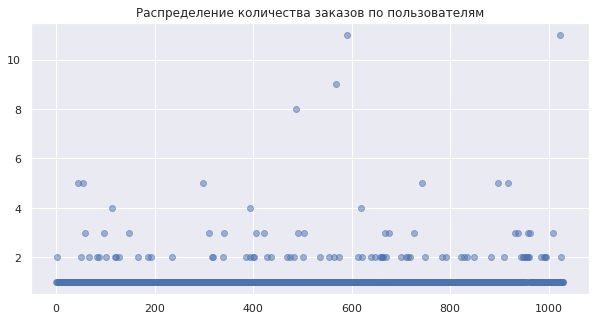

In [27]:
x_values = pd.Series(range(0,len(orders_by_users)))

# строим точечный график
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('Распределение количества заказов по пользователям');

Большинство пользователей оформляли заказ один раз, но есть и заметная доля пользователей с 2-3 заказами. Их точная доля не ясна, поэтому сложно понять, можно ли считать их выбросами или нет.  
Посчитаем **95-й и 99-й перцентили количества заказов на пользователя** и выберем границу для определения аномальных пользователей.

In [28]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше двух заказов. И 1% пользователей заказывали более четырёх раз. 
Разумно выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>

Отлично)

Построим **точечный график стоимостей заказов**. 

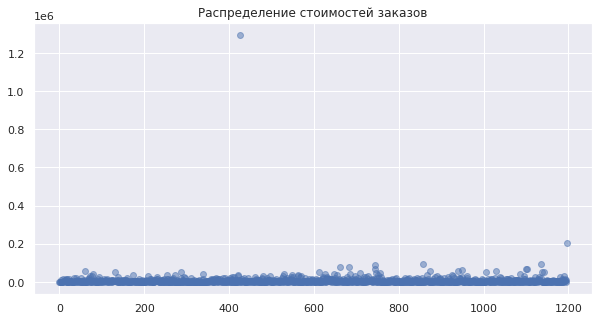

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечный график
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Распределение стоимостей заказов');

Мы видим два сильно выбивающихся по стоимости заказа (на уровне 200 тыс и 1,3 млн), которые вызвали всплеск на графиках кумулятивных метрик, а также другие весомые заказы, которые могут повлиять на результат исследований.

Построим аналогичный график без двух крупных выбросов.

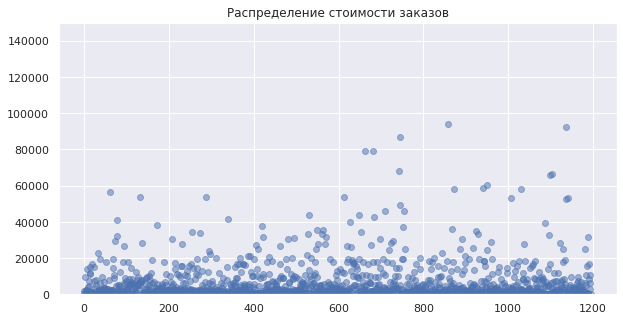

In [30]:
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Распределение стоимости заказов');

Мы видим, что основная масса заказов не превышает 20000.

Посчитаем **95-й и 99-й перцентили стоимости заказов**:

In [31]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Установим границу для определения аномалий на величине 99-го перцентиля = 58233.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>

Границы аномальных значений определены правильно) Здорово, что ты построил еще один график с основной суммой заказов)

### **Анализ статистической значимости**

**Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Сформулируем гипотезы.  
Нулевая: различий в среднем количестве заказов между группами нет.  
Альтернативная: различия в среднем между группами есть.

Начнём с подготовки данных.

Так как данные о продажах и средних чеках редко бывают нормально распределены (это классический пример переменных, подверженных выбросам), для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.  
Для уровня значимости установим стандартный уровень статистической значимости, равный 0.05.

In [32]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head(6)

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935


У нас получилсь таблица с такими названиями столбцов:

date — дата;  
orders_daily_a — количество заказов в выбранную дату в группе A;  
revenue_per_date_a — суммарная выручка в выбранную дату в группе A  
orders_daily_b — количество заказов в выбранную дату в группе B;  
revenue_per_date_b — суммарная выручка в выбранную дату в группе B;  
orders_cummulative_a — суммарное число заказов до выбранной даты включительно в группе A;  
revenue_cummulative_a — суммарная выручка до выбранной даты включительно в группе A;  
orders_cummulative_b — суммарное количество заказов до выбранной даты включительно в группе B;  
revenue_cummulative_b — суммарная выручка до выбранной даты включительно в группе B;  
visitors_per_date_a — количество пользователей в выбранную дату в группе A;  
visitors_per_date_b — количество пользователей в выбранную дату в группе B;  
visitors_cummulative_a — количество пользователей до выбранной даты включительно в группе A;  
visitors_cummulative_b — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные orders_by_users_a и orders_by_users_b.  
В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [33]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов.  
Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [34]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0 )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0 )

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

Напомним, что в sample_a сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sample_a — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sample_a методом mean(). Аналогично найдём среднее группы B: sample_b.mean().

Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

In [35]:
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a, sample_b)[1]
print("P-value: {0:.3f}".format(p_value))
if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
print("Относительный прирост В к А: {0:.2%}".format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.81%


Таким образом, по "сырым" данным различия в среднем количестве заказов на посетителя между группами есть.  
P-value = 0.017 меньше alpha = 0.05. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет, отвергаем. 
Относительный выигрыш группы B равен 13.81%.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>
    
Гипотезы сформулированы верно и значение p-value интерпретировано правильно. Хорошая работа.
</div>

Посчитаем **статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**.

Нулевая гипотеза: различий в среднем чеке между группами нет.  
Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Уровень значимости оставим тот же: alpha = 0.05 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами:

In [36]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия в среднем чеке между группами: {0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Относительные различия в среднем чеке между группами: 25.87%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Поскольку относительное различие среднего чека между сегментами составляет ~26%, наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно, например, из-за аномальных значений в "сырых" данных.

**Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 58233.  
Так мы уберём 1% пользователей с наибольшим числом заказов и около 1% пользователей с дорогими заказами.  
Сделаем срезы пользователей с числом заказов больше 4 — users_with_many_orders и пользователей, совершивших заказы дороже 58233 — users_with_expensive_orders.  
Объединим их в таблице abnormal_users.  
Узнаем, сколько всего аномальных пользователей методом shape().

In [37]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)

users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 v_2 <a class="tocSkip"> </h2>

Очень хорошо)

Всего 15 аномальных пользователей.  
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.  
Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [38]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [39]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост В к А: {0:.2%}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

P-value: 0.014
Относительный прирост В к А: 15.33%


P-value = 0.014 меньше alpha = 0.05. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет, отвергаем. Относительный выигрыш группы B равен 15.33%.  
Таким образом, и по "очищенным" данным различия в среднем количестве заказов на посетителя между группами есть.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 <a class="tocSkip"> </h2>

Верно)

**Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [40]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост В к А: {0:.2%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.851
Относительный прирост В к А: -0.57%


P-value = 0.851 больше alpha = 0.05. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, отвергнуть не можем. Относительного прироста практически нет.  
Таким образом, и по "очищенным" данным различия в среднем чеке заказа между группами нет, но теперь это логично увязывается с отсутствием значимого прироста.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 <a class="tocSkip"> </h2>

Статистический анализ проведен верно, молодец)

## Вывод:

1. Проведя приоритезацию гипотез из списка, предоставленного отделом Маркетинга, рекомендовано в первую очередь обратить внимание на гипотезы:  
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

2. По результатам анализа А/В теста:

 - Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по «сырым», так и по очищенным от аномалий данным. Относительный прирост группы B равен 15.33%;

 - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом средний чек группы В по "сырым" данным значительно выше среднего чека группы A (на 25,87%), а по очищенным данным различия между группами нет, что говорит о вредном влиянии аномальных значений и о пользе их фильтрации;

 - График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показывает, что результаты группы В стабильно лучше группы А;  

**Исходя из обнаруженных фактов, тест следует остановить и признать его успешным, зафиксировав победу группы B (её среднее количество заказов на посетителя выше чем у группы А).**

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 <a class="tocSkip"> </h2>

Содержательный вывод по проделанной работе)

<div style="border:solid Purple 2px; padding: 40px">

<h2> Общий комментарий ревьюера 😊 v_2<a class="tocSkip"> </h2>
    <br/>
Александр, спасибо за проект! Успехов в дальнейшем обучении!)
   